# KAN_fast KAN网络的改进

## 通过研读论文理解论文含义，观看视频讲解，下载github项目并运行，我们得到以下结论：
### KAN网络原始实现的性能问题主要在于它需要扩展所有中间变量以执行不同的激活函数。对于具有 in_features 个输入和 out_features 个输出的层，原始实现需要将输入扩展为形状为 (batch_size, out_features, in_features) 的张量以执行激活函数。然而，所有激活函数都是一组固定基函数（B 样条）的线性组合；鉴于此，拟将计算重新表述为用不同的基函数激活输入，然后将它们线性组合。这种重新表述可以显著减少内存消耗，并使计算变得更加简单的矩阵乘法，自然地适用于前向和后向传递。

### 稀疏化被认为对 KAN 的可解释性至关重要。作者提出了一种定义在输入样本上的 L1 正则化，它需要对 (batch_size, out_features, in_features) 张量进行非线性操作，因此与重新表述不兼容。拟改为对权重进行 L1 正则化，这在神经网络中更为常见，并且与重新表述兼容。

### 除了可学习的激活函数（B 样条），原始实现还包括对每个激活函数的可学习缩放。拟提供了一个名为 enable_standalone_scale_spline 的选项，默认情况下为 True 以包含此功能；禁用它会使模型更高效，但可能会影响结果。这也需要更多实验来验证。

综上，拟做以下改进：
1.内存效率提升:
原始实现需要扩展所有中间变量来执行不同的激活函数，而此代码中将计算重新制定为使用不同的基函数激活输入。
然后线性组合它们。这种重新制定可以显著降低内存成本，并将计算变得更加高效。
2.正则化方法的改变:
原始实现中使用的L1正则化需要对张量进行非线性操作，与重新制定的计算不兼容。
因此，此代码中将L1正则化改为对权重的L1正则化，这更符合神经网络中常见的正则化方法，并且与重新制定的计算兼容。
3.激活函数缩放选项:
原始实现中包括了每个激活函数的可学习缩放，但这个库提供了一个选项来禁用这个特性。
禁用缩放可以使模型更加高效，但可能会影响结果。
4.参数初始化的改变：
为了解决在MNIST数据集上的性能问题，此代码修改了参数的初始化方式使用kaiming初始化.


## 代码实现
### KAN_fast.py

In [1]:
import torch
import torch.nn.functional as F
import math

"""
1.内存效率提升：原始实现需要扩展所有中间变量来执行不同的激活函数，而此代码中将计算重新制定为使用不同的基函数激活输入，
  然后线性组合它们。这种重新制定可以显著降低内存成本，并将计算变得更加高效。

2.正则化方法的改变：原始实现中使用的L1正则化需要对张量进行非线性操作，与重新制定的计算不兼容。
  因此，此代码中将L1正则化改为对权重的L1正则化，这更符合神经网络中常见的正则化方法，并且与重新制定的计算兼容。

3.激活函数缩放选项：原始实现中包括了每个激活函数的可学习缩放，但这个库提供了一个选项来禁用这个特性。
  禁用缩放可以使模型更加高效，但可能会影响结果。

4.参数初始化的改变：为了解决在MNIST数据集上的性能问题，此代码修改了参数的初始化方式，使用kaiming初始化。
"""

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,  # 网格大小，默认为 5
        spline_order=3, # 分段多项式的阶数，默认为 3
        scale_noise=0.1,  # 缩放噪声，默认为 0.1
        scale_base=1.0,   # 基础缩放，默认为 1.0
        scale_spline=1.0,    # 分段多项式的缩放，默认为 1.0
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,  # 基础激活函数，默认为 SiLU（Sigmoid Linear Unit）
        grid_eps=0.02,
        grid_range=[-1, 1],  # 网格范围，默认为 [-1, 1]
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size # 设置网格大小和分段多项式的阶数
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size   # 计算网格步长
        grid = ( # 生成网格
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0] 
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)  # 将网格作为缓冲区注册

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features)) # 初始化基础权重和分段多项式权重
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:  # 如果启用独立的分段多项式缩放，则初始化分段多项式缩放参数
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise # 保存缩放噪声、基础缩放、分段多项式的缩放、是否启用独立的分段多项式缩放、基础激活函数和网格范围的容差
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()  # 重置参数

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)# 使用 Kaiming 均匀初始化基础权重
        with torch.no_grad():
            noise = (# 生成缩放噪声
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_( # 计算分段多项式权重
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:  # 如果启用独立的分段多项式缩放，则使用 Kaiming 均匀初始化分段多项式缩放参数
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        计算给定输入张量的 B-样条基函数。

        参数:
        x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。

        返回:
        torch.Tensor: B-样条基函数张量，形状为 (batch_size, in_features, grid_size + spline_order)。
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = ( # 形状为 (in_features, grid_size + 2 * spline_order + 1)
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        计算插值给定点的曲线的系数。

        参数:
        x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
        y (torch.Tensor): 输出张量，形状为 (batch_size, in_features, out_features)。
        返回:
        torch.Tensor: 系数张量，形状为 (out_features, in_features, grid_size + spline_order)。
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        # 计算 B-样条基函数
        A = self.b_splines(x).transpose(
            0, 1 # 形状为 (in_features, batch_size, grid_size + spline_order)
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features) # 形状为 (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(   # 使用最小二乘法求解线性方程组
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)  # 形状为 (in_features, grid_size + spline_order, out_features)
        result = solution.permute( # 调整结果的维度顺序
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        """
        获取缩放后的分段多项式权重。

        返回:
        torch.Tensor: 缩放后的分段多项式权重张量，形状与 self.spline_weight 相同。
        """
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor): # 将输入数据通过模型的各个层，经过线性变换和激活函数处理，最终得到模型的输出结果
        """
        前向传播函数。

        参数:
        x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。

        返回:
        torch.Tensor: 输出张量，形状为 (batch_size, out_features)。
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight) # 计算基础线性层的输出
        spline_output = F.linear( # 计算分段多项式线性层的输出
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output  # 返回基础线性层输出和分段多项式线性层输出的和

    @torch.no_grad()
    # 更新网格。
    # 参数:
    # x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
    # margin (float): 网格边缘空白的大小。默认为 0.01。
    # 根据输入数据 x 的分布情况来动态更新模型的网格,使得模型能够更好地适应输入数据的分布特点，从而提高模型的表达能力和泛化能力。
    def update_grid(self, x: torch.Tensor, margin=0.01): 
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)  # 计算 B-样条基函数
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)  # 调整维度顺序为 (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)  # 调整维度顺序为 (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0] # 对每个通道单独排序以收集数据分布
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)   # 更新网格和分段多项式权重
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        # 计算正则化损失，用于约束模型的参数，防止过拟合
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        """
        计算正则化损失。

        这是对原始 L1 正则化的简单模拟，因为原始方法需要从扩展的（batch, in_features, out_features）中间张量计算绝对值和熵，
        而这个中间张量被 F.linear 函数隐藏起来，如果我们想要一个内存高效的实现。

        现在的 L1 正则化是计算分段多项式权重的平均绝对值。作者的实现也包括这一项，除了基于样本的正则化。

        参数:
        regularize_activation (float): 正则化激活项的权重，默认为 1.0。
        regularize_entropy (float): 正则化熵项的权重，默认为 1.0。

        返回:
        torch.Tensor: 正则化损失。
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module): # 封装了一个KAN神经网络模型，可以用于对数据进行拟合和预测。
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        """
        初始化 KAN 模型。

        参数:
            layers_hidden (list): 包含每个隐藏层输入特征数量的列表。
            grid_size (int): 网格大小，默认为 5。
            spline_order (int): 分段多项式的阶数，默认为 3。
            scale_noise (float): 缩放噪声，默认为 0.1。
            scale_base (float): 基础缩放，默认为 1.0。
            scale_spline (float): 分段多项式的缩放，默认为 1.0。
            base_activation (torch.nn.Module): 基础激活函数，默认为 SiLU。
            grid_eps (float): 网格调整参数，默认为 0.02。
            grid_range (list): 网格范围，默认为 [-1, 1]。
        """
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False): # 调用每个KANLinear层的forward方法，对输入数据进行前向传播计算输出。
        """
        前向传播函数。

        参数:
            x (torch.Tensor): 输入张量，形状为 (batch_size, in_features)。
            update_grid (bool): 是否更新网格。默认为 False。

        返回:
            torch.Tensor: 输出张量，形状为 (batch_size, out_features)。
        """
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):#计算正则化损失的方法，用于约束模型的参数，防止过拟合。
        """
        计算正则化损失。

        参数:
            regularize_activation (float): 正则化激活项的权重，默认为 1.0。
            regularize_entropy (float): 正则化熵项的权重，默认为 1.0。

        返回:
            torch.Tensor: 正则化损失。
        """
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )


## 测试代码，使用mnist数据集测试KAN_fast模型

### 1.加载数据集

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load MNIST
# 定义数据预处理转换：将图像转换为张量，并进行归一化
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
# 创建训练数据集
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
# 创建训练数据加载器
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 931981.26it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 131099.09it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:04<00:00, 379482.13it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9015867.85it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw


### 2.定义模型

In [22]:
# Define model
model = KAN([28 * 28, 64, 10]) # 输入特征为28*28，有一个隐藏层（64个神经元），输出层有10个神经元，用于手写数字分类任务
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 打印模型参数数量
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

# 将模型移动到可用的设备上（GPU 或 CPU）
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# 定义优化器
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# 定义损失函数 计算模型输出与实际标签之间的损失
criterion = nn.CrossEntropyLoss()


Number of parameters: 508160


### 3.训练模型

In [17]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# 用于记录训练和验证的损失和准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

for epoch in range(10):
    start_time = time.time()  # 记录当前epoch的开始时间
    # 训练阶段
    model.train()
    train_loss = 0
    train_accuracy = 0
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)  # 将图像数据展平为一维张量，并移到指定设备上
            optimizer.zero_grad() # 梯度清零
            output = model(images) # 前向传播计算输出
            loss = criterion(output, labels.to(device)) # 计算损失
            loss.backward() # 反向传播
            optimizer.step()  # 更新优化器参数

            train_loss += loss.item()
            train_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()

            pbar.set_postfix(loss=loss.item(), accuracy=(output.argmax(dim=1) == labels.to(device)).float().mean().item(), lr=optimizer.param_groups[0]['lr'])

    train_loss /= len(trainloader)
    train_accuracy /= len(trainloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 验证阶段
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()
    
    end_time = time.time()  # 记录当前epoch的结束时间
    epoch_time = end_time - start_time  # 计算当前epoch的持续时间
    epoch_times.append(epoch_time)  # 记录持续时间

    print(f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")


100%|██████████| 938/938 [00:12<00:00, 77.26it/s, accuracy=0.906, loss=0.299, lr=0.001] 


Epoch 1, Val Loss: 0.22986625143249703, Val Accuracy: 0.9326234076433121


100%|██████████| 938/938 [00:11<00:00, 78.33it/s, accuracy=0.906, loss=0.207, lr=0.0008] 


Epoch 2, Val Loss: 0.16232301824233808, Val Accuracy: 0.9529259554140127


100%|██████████| 938/938 [00:11<00:00, 79.00it/s, accuracy=0.969, loss=0.0819, lr=0.00064]


Epoch 3, Val Loss: 0.13194065666787183, Val Accuracy: 0.9607882165605095


100%|██████████| 938/938 [00:12<00:00, 77.97it/s, accuracy=1, loss=0.0142, lr=0.000512]    


Epoch 4, Val Loss: 0.11500852052893513, Val Accuracy: 0.9656648089171974


100%|██████████| 938/938 [00:12<00:00, 77.94it/s, accuracy=1, loss=0.0775, lr=0.00041]    


Epoch 5, Val Loss: 0.10392475125059533, Val Accuracy: 0.9702428343949044


100%|██████████| 938/938 [00:12<00:00, 77.58it/s, accuracy=1, loss=0.0337, lr=0.000328]    


Epoch 6, Val Loss: 0.09699491749645157, Val Accuracy: 0.9697452229299363


100%|██████████| 938/938 [00:11<00:00, 79.85it/s, accuracy=1, loss=0.042, lr=0.000262]     


Epoch 7, Val Loss: 0.09529946388151782, Val Accuracy: 0.971437101910828


100%|██████████| 938/938 [00:11<00:00, 78.46it/s, accuracy=1, loss=0.0272, lr=0.00021]    


Epoch 8, Val Loss: 0.09206455424324177, Val Accuracy: 0.9717356687898089


100%|██████████| 938/938 [00:11<00:00, 79.62it/s, accuracy=1, loss=0.0337, lr=0.000168]    


Epoch 9, Val Loss: 0.08946938265061635, Val Accuracy: 0.9723328025477707


100%|██████████| 938/938 [00:11<00:00, 79.00it/s, accuracy=0.969, loss=0.166, lr=0.000134] 


Epoch 10, Val Loss: 0.08987779363323964, Val Accuracy: 0.9721337579617835


### 绘制损失函数图

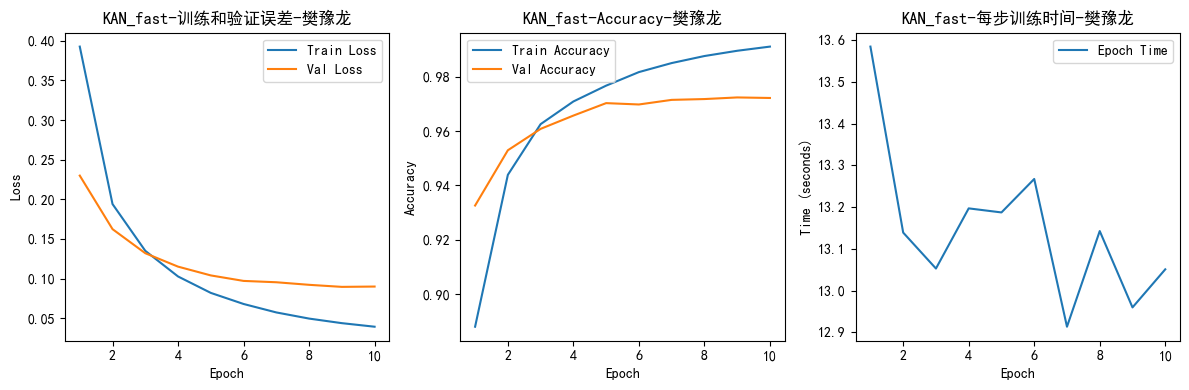

In [27]:
# 绘制损失函数图
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KAN_fast-训练和验证误差-樊豫龙')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('KAN_fast-Accuracy-樊豫龙')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), epoch_times, label='Epoch Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('KAN_fast-每步训练时间-樊豫龙')
plt.legend()

plt.tight_layout()
plt.show()

## 对比KAN_fast,KAN,mlp，我们可以看出来KAN_fast的性能不错，它的准确率更高，损失更低，训练时间接近mlp，远远小于KAN源码（KAN很慢）。

In [24]:
torch.save(model.state_dict(), "./models/kan_fast.pth")